<font size=6><center> Machine Learning - Assignment 2 </center><br></font>
    <font size=5><center> Neural Networks weights optimization</center></font>

<font size="4"><center>Author: Mohamed Amine DASSOULI </center></font>

<a id='1'></a>
# Importations

In [1]:
import pandas as pd
import numpy as np 

from numpy.random import seed

import neural_network_custom as custom_nn
import opt_algorithms_custom as custom_alg

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline, BSpline

from sklearn import svm
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam

import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

plt.style.use('ggplot')
import time

<a id='2'></a>
# Configuration

In [2]:
PATH_CSV_DATA = "Data/Car_Evaluation.txt"

<a id='3'></a>
# Functions

In [3]:
def encode_column(col: np.ndarray, max_unique_values: int = 100) -> np.ndarray:
    """
    Encode a numpy array
    
    Parameters
    ----------
    col : numpy 1D-Array
    max_unique_values : int, default 100
        Limit the number of unique values to use
        Take the most occurents and regroup all the others in one value

    Returns
    -------
    numpy 2D-Array
        Encoded Array
    
    
    """
    # Get the unique values and their frequences in the list
    col_values = np.unique(col, return_counts=True)
    
    # If there are only two unique values, we use a labelencoder, otherwise we use a onehotencoder
    n_unique_values = len(col_values[0]) 
    if n_unique_values <=2 : 
        labelencoder = LabelEncoder()
        encoded_col = labelencoder.fit_transform(col.reshape((len(col), 1)))
    else:
        # Find the `max_unique_values` most occurent unique values in the column
        col_values = [(val,freq) for (val,freq) in zip(col_values[0], col_values[1])]
        col_values.sort(key=lambda x: x[1])
        values_keep = [col_values[i][0] for i in range(min(max_unique_values, n_unique_values))]
        
        # Keep the most occurent unique values, and change all the others to a value "Others"
        col = np.array([value if value in values_keep else "Others" for value in col])
        
        # Use a hot encoder
        onehotencoder = OneHotEncoder()
        encoded_col = onehotencoder.fit_transform(col.reshape((len(col), 1))).toarray()
    
    return encoded_col

<a id='4'></a>
# Visualizing data

In [4]:
headers = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'car']

# Loading data 
df_data = pd.read_csv(PATH_CSV_DATA, names=headers)

# Shuffle the data 
df_data = df_data.sample(frac=1).reset_index(drop=True)

# View the dataframe
df_data.head(20)

,buying,maint,doors,persons,lug_boot,safety,car
0,med,high,5more,2,big,low,unacc
1,high,high,3,2,small,med,unacc
2,vhigh,high,3,more,med,low,unacc
3,high,vhigh,3,4,small,low,unacc
4,med,high,3,more,med,med,acc
5,med,vhigh,5more,2,small,high,unacc
6,low,high,5more,more,med,low,unacc
7,med,high,4,more,big,low,unacc
8,med,med,3,2,med,high,unacc
9,med,vhigh,5more,4,big,med,acc


### Basic information

In [5]:
# Visualize basic information about the data
print(f"- Data shape : {df_data.shape}\n")
print(f"- Keys :\n\n{df_data.dtypes}")

- Data shape : (1728, 7)

- Keys :

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
car         object
dtype: object


### Missing data

In [6]:
# Check if there is any missing data 
df_data.isna().any()

buying      False
maint       False
doors       False
persons     False
lug_boot    False
safety      False
car         False
dtype: bool

<font size="3"> ==> There is not any NaN cell. Therefore, there is no missing data ! </font>

### Data balancing

<font size="3"> Let's look at the data and check if there is any imbalance </font>


([<matplotlib.patches.Wedge at 0x7fcd4649f6d0>,
 [Text(-0.6472108044769336, 0.8894482416466517, 'Unacceptable'),
  Text(0.413550280063065, -1.0193018031278867, 'Acceptable'),
  Text(1.0287904004528587, -0.3893460054194043, 'Good'),
  Text(1.0923282302660486, -0.12968823140070448, 'Very good')],
 [Text(-0.35302407516923645, 0.48515358635271905, '70.02%'),
  Text(0.22557288003439907, -0.5559828017061199, '22.22%'),
  Text(0.5611584002470138, -0.21237054841058414, '3.99%'),
  Text(0.5958153983269355, -0.07073903530947516, '3.76%')])

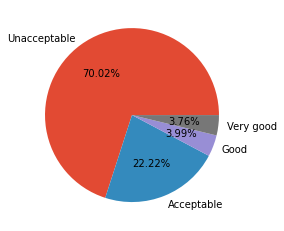

In [7]:
num_samples = df_data.shape[0]
classes = pd.value_counts(df_data["car"])
plt.pie(classes.values[:], labels=["Unacceptable", "Acceptable", "Good", "Very good"], autopct=lambda p: f"{p:.2f}%")

<font size='3'> ==> The data is very imbalanced. We are going to combine the 3 minority classes ("Acceptable", "Good" and "Very good") in order to get a binary classification problem and have more balanced data.</font>

## <font size="3"> Do undersampling to balance data:</font>

([<matplotlib.patches.Wedge at 0x7fcd46405790>,
 [Text(-0.6472108044769336, 0.8894482416466517, 'Unacceptable'),
  Text(0.6472108044769331, -0.889448241646652, 'Acceptable')],
 [Text(-0.35302407516923645, 0.48515358635271905, '70.02%'),
  Text(0.35302407516923623, -0.4851535863527192, '29.98%')])

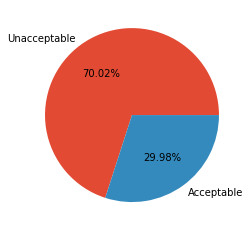

In [8]:
# Turn "Good" and "Very Good" classes into "Acceptable"
df_data.loc[df_data["car"] == "good", "car"] = "acc"
df_data.loc[df_data["car"] == "vgood", "car"] = "acc"


# Let's look at new class partition
num_samples = df_data.shape[0]
classes = pd.value_counts(df_data["car"])
plt.pie(classes.values[:], labels=["Unacceptable", "Acceptable"], autopct=lambda p: f"{p:.2f}%")


<a id='5'></a>
# Data Preprocessing

<font size="3"> For this dataset, all the features seem to be useful, so we keep all of them.</font>

Let's take a look at the columns <b>'doors' and 'persons'</b> to see how many unique values they have:

In [9]:
df_data.doors.unique()

array(['5more', '3', '4', '2'], dtype=object)

In [10]:
df_data.persons.unique()

array(['2', 'more', '4'], dtype=object)

In [11]:
Categorical_X = df_data.values[:,:-1]
Y = df_data.values[:,-1]

## <font size="3"> Encoding Categorical data :</font>

In [12]:
# Prepare the features
features = []
for i in range(6):
    col_encoded = encode_column(Categorical_X[:,i], 20)
    features.append(np.reshape(col_encoded, (Categorical_X.shape[0], -1)))

X = np.concatenate((features), axis=1)

print(f"Shape of X : {X.shape}")

Shape of X : (1728, 21)


## <font size="3"> Turning Y into binary values "0" for Unacceptable and "1" for Acceptable :</font>

In [13]:
Y = [0 if label=="unacc" else 1 for label in Y]

## <font size="3"> Splitting the dataset into training and testing sets :</font>

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 10, stratify=Y)

In [15]:
print('Size of train data :', len(X_train))
print('Size of test data :', len(X_test))

Size of train data : 1382
Size of test data : 346


<a id='6'></a>
# Neural Network 

0.3024602026049204
0.2981186685962373
0.2981186685962373
0.6801736613603473
0.2945007235890014
0.2981186685962373
0.715629522431259
0.7134587554269175
0.7178002894356006


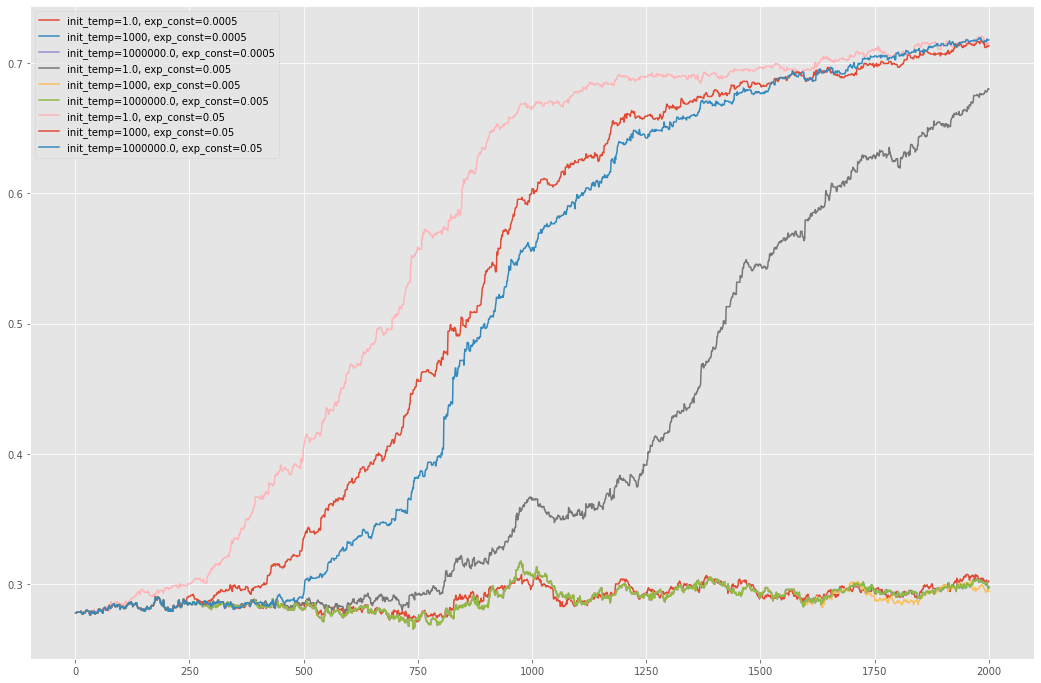

In [16]:
# Grid search for Simulated Annealing
exp_const_values = [0.0005, 0.005, 0.05]
init_temp_values = [1.0, 1000, 1e6]
plt.figure(figsize=(18,12))
for exp_const in exp_const_values:
    for init_temp in init_temp_values:
        model_sa_tune= custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                                 algorithm = 'simulated_annealing', max_iters = 2000,
                                 bias = True, is_classifier = True, clip_max = 1000, max_attempts = 50,
                                 random_state = 1, curve = True, schedule=mlrose.ExpDecay(init_temp=init_temp,
                                                                                            exp_const=exp_const, 
                                                                                            min_temp=0.001))
        _, state_sa, train_acc_sa, test_acc_sa, times_sa, iterations_sa = model_sa_tune.fit(X_train, y_train,
                                                                                            x_test=X_test,
                                                                                            y_test=y_test)
        print(train_acc_sa[-1])
        plt.plot(iterations_sa, train_acc_sa, label = f"init_temp={init_temp}, exp_const={exp_const}")
plt.legend()
plt.show()

0.7178002894356006
0.3147612156295224
0.2981186685962373


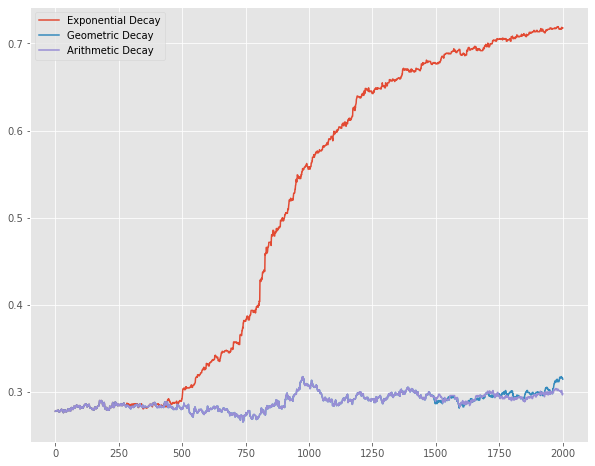

In [17]:
# Trying different decay schedules for Simulated Annealing
plt.figure(figsize=(10,8))

# Exponential Decay
model_sa_tune= custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                         algorithm = 'simulated_annealing', max_iters = 2000,
                         bias = True, is_classifier = True, clip_max = 1000, max_attempts = 50,
                         random_state = 1, curve = True, schedule=mlrose.ExpDecay(init_temp=1e6,
                                                                                    exp_const=0.05, 
                                                                                    min_temp=0.001))
_, state_sa, train_acc_sa, test_acc_sa, times_sa, iterations_sa = model_sa_tune.fit(X_train, y_train,
                                                                                    x_test=X_test,
                                                                                    y_test=y_test)

print(train_acc_sa[-1])
plt.plot(iterations_sa, train_acc_sa, label = "Exponential Decay")

# Geometric Decay
model_sa_tune= custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                         algorithm = 'simulated_annealing', max_iters = 2000,
                         bias = True, is_classifier = True, clip_max = 1000, max_attempts = 50,
                         random_state = 1, curve = True, schedule=mlrose.GeomDecay(init_temp=1e6,
                                                                                    decay=0.99, 
                                                                                    min_temp=0.001))
_, state_sa, train_acc_sa, test_acc_sa, times_sa, iterations_sa = model_sa_tune.fit(X_train, y_train,
                                                                                    x_test=X_test,
                                                                                    y_test=y_test)

print(train_acc_sa[-1])
plt.plot(iterations_sa, train_acc_sa, label = "Geometric Decay")


# Arithmetic Decay
model_sa_tune= custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                         algorithm = 'simulated_annealing', max_iters = 2000,
                         bias = True, is_classifier = True, clip_max = 1000, max_attempts = 50,
                         random_state = 1, curve = True, schedule=mlrose.ArithDecay(init_temp=1e6,
                                                                                    decay=0.0001, 
                                                                                    min_temp=0.001))
_, state_sa, train_acc_sa, test_acc_sa, times_sa, iterations_sa = model_sa_tune.fit(X_train, y_train,
                                                                                    x_test=X_test,
                                                                                    y_test=y_test)

print(train_acc_sa[-1])
plt.plot(iterations_sa, train_acc_sa, label = "Arithmetic Decay")

plt.legend()
plt.show()



0.7865412445730825
0.7525325615050651
0.7720694645441389
0.7214182344428365
0.7192474674384949
0.7872648335745297
0.7829232995658466
0.7727930535455861
0.8299565846599132


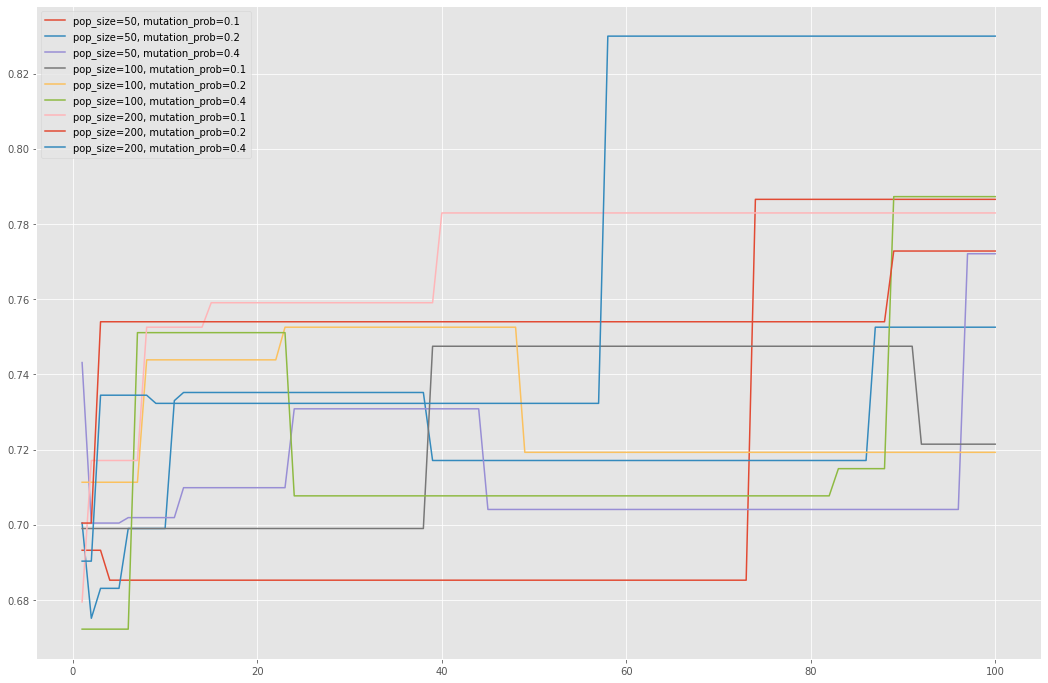

In [18]:
# Grid search for Genetic Algorithm
pop_size_values = [50, 100, 200]
mutation_prob_values = [0.1, 0.2, 0.4]

plt.figure(figsize=(18,12))
for pop_size in pop_size_values:
    for mutation_prob in mutation_prob_values:
        nn_model_ga_tune = custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                                 algorithm = 'genetic_alg', pop_size = pop_size, mutation_prob = mutation_prob,
                                 max_iters = 100, bias = True, is_classifier = True, clip_max = 1, 
                                 max_attempts = 50, random_state = 1, curve = True)
        _, state_ga, train_acc_ga, test_acc_ga, times_ga, iterations_ga = nn_model_ga_tune.fit(X_train,y_train,
                                                                                  x_test = X_test, 
                                                                                  y_test = y_test)
        print(train_acc_ga[-1])
        plt.plot(iterations_ga, train_acc_ga, label = f"pop_size={pop_size}, mutation_prob={mutation_prob}")
plt.legend()
plt.show()

In [33]:
# Initialize neural network object and fit object
#RHC
nn_model_rhc= custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                                 algorithm = 'random_hill_climb', max_iters = 18000,
                                 bias = True, is_classifier = True,
                                 early_stopping = True, clip_max = 100000, max_attempts = 1000,
                                 random_state = 1, curve = True)

#SA
nn_model_sa= custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                                 algorithm = 'simulated_annealing', max_iters = 18000,
                                 bias = True, is_classifier = True, clip_max = 1, max_attempts = 1000,
                                 random_state = 10, curve = True, schedule=mlrose.ExpDecay(init_temp=1e6,
                                                                                    exp_const=0.05, 
                                                                                    min_temp=0.001))
#GA
nn_model_ga= custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                                 algorithm = 'genetic_alg', pop_size = 200, mutation_prob = 0.2,
                                 max_iters = 18000,
                                 bias = True, is_classifier = True,
                                 early_stopping = False, clip_max = 1, max_attempts = 2000,
                                 random_state = 0, curve = True)

#Backprop
nn_model_bp= custom_nn.NeuralNetwork(hidden_nodes = [16, 4], activation = 'relu',
                                 algorithm = 'back_prop', learning_rate=0.001,
                                 max_iters = 18000,
                                 bias = True, is_classifier = True,
                                 early_stopping = False, clip_max = 1, max_attempts = 3000,
                                 random_state = 0, curve = True)

In [34]:
_, state_rhc, train_acc_rhc, test_acc_rhc, times_rhc, iterations_rhc = nn_model_rhc.fit(X_train, y_train,
                                                                                        x_test = X_test, 
                                                                                        y_test = y_test)
_, state_sa, train_acc_sa, test_acc_sa, times_sa, iterations_sa = nn_model_sa.fit(X_train,y_train,
                                                                                  x_test = X_test, 
                                                                                  y_test = y_test)
_, state_ga, train_acc_ga, test_acc_ga, times_ga, iterations_ga = nn_model_ga.fit(X_train,y_train,
                                                                                  x_test = X_test, 
                                                                                  y_test = y_test)

_, state_bp, train_acc_bp, test_acc_bp, times_bp, iterations_bp = nn_model_bp.fit(X_train,y_train,
                                                                                  x_test = X_test, 
                                                                                  y_test = y_test)

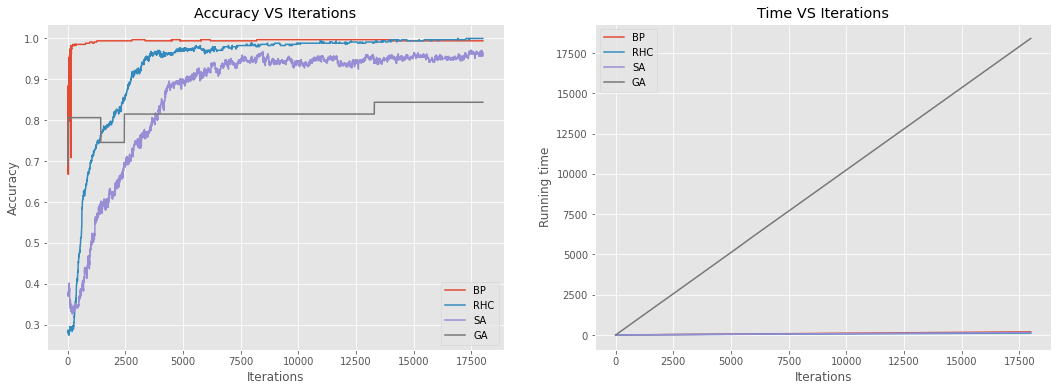

In [35]:
fig=plt.figure(figsize=(18,6))
ax1=fig.add_subplot(1,2,1)
plt.plot(iterations_bp, test_acc_bp, label = 'BP')
plt.plot(iterations_rhc, test_acc_rhc, label = 'RHC')
plt.plot(iterations_sa, test_acc_sa, label = 'SA')
plt.plot(iterations_ga, test_acc_ga, label = 'GA')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title ("Accuracy VS Iterations")
ax2=fig.add_subplot(1,2,2)
plt.plot(iterations_bp,times_bp, label = 'BP')
plt.plot(iterations_rhc,times_rhc, label = 'RHC')
plt.plot(iterations_sa,times_sa, label = 'SA')
plt.plot(iterations_ga,times_ga, label = 'GA')
plt.xlabel("Iterations")
plt.ylabel("Running time")
plt.title("Time VS Iterations")
plt.legend()
plt.show()

In [50]:
print(test_acc_ga[-5000])

0.815028901734104


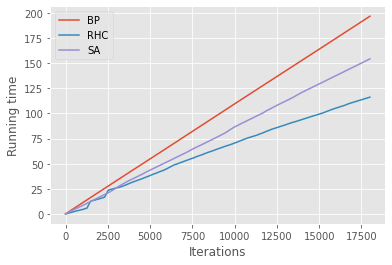

In [40]:
plt.plot(iterations_bp,times_bp, label = 'BP')
plt.plot(iterations_rhc,times_rhc, label = 'RHC')
plt.plot(iterations_sa,times_sa, label = 'SA')
plt.xlabel("Iterations")
plt.ylabel("Running time")
plt.legend()

In [44]:
print(times_rhc[-1]/18000)

0.006457750784026252


In [43]:
print(times_sa[-1]/18000)

0.008574775165981716


In [42]:
print(times_bp[-1]/18000)

0.010932113342814975


In [48]:
print(times_ga[-1]/0.00646/18000)

158.25967590629256
